# Model Klasifikasi Jenis Bunga

In [1]:

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Understanding

In [2]:
# Mendefinisikan direktori utama dataset
#dataset ini upload terlebih dulu ke drive agar bisa di load di google colab,
#atau kalian bisa langsung download lewat kaggle langsung di google colab

import os
base_dir =( '/content/drive/My Drive/praktikum 11/flowers')

In [3]:
print(os.listdir(base_dir))

['tulip', 'sunflower', 'rose', 'dandelion', 'daisy']


In [4]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 515


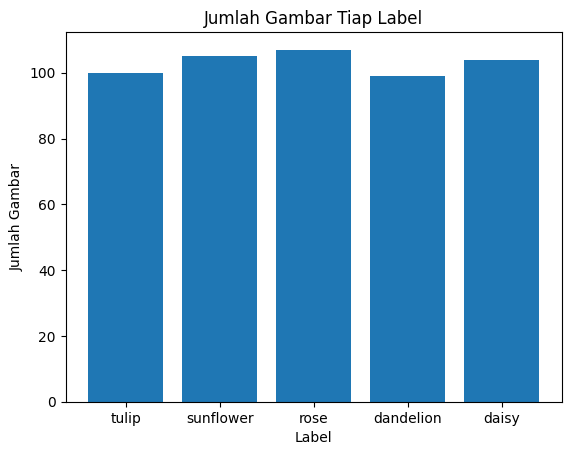

In [5]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

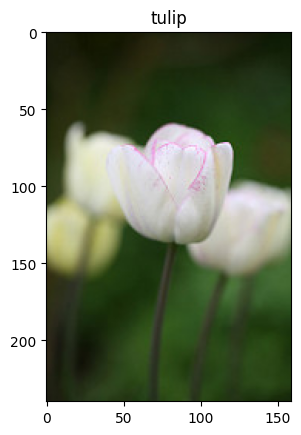

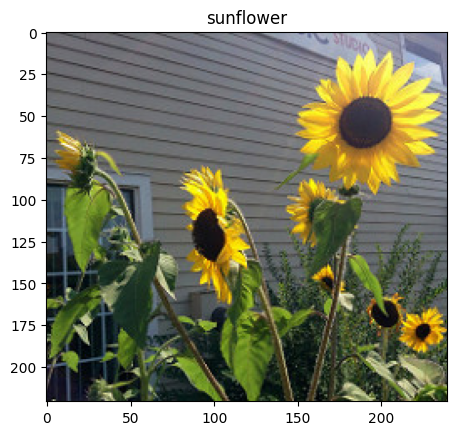

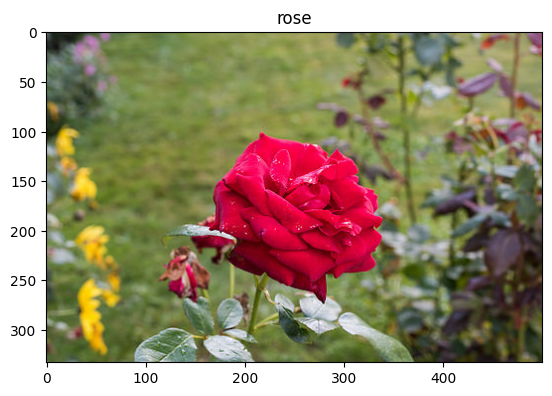

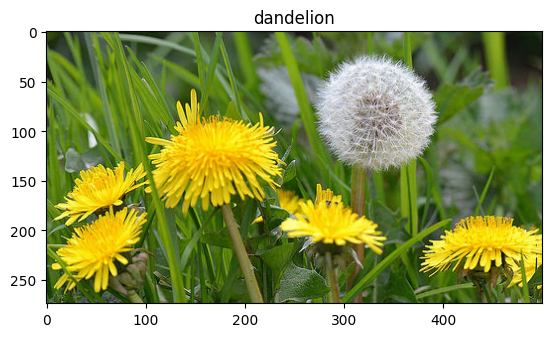

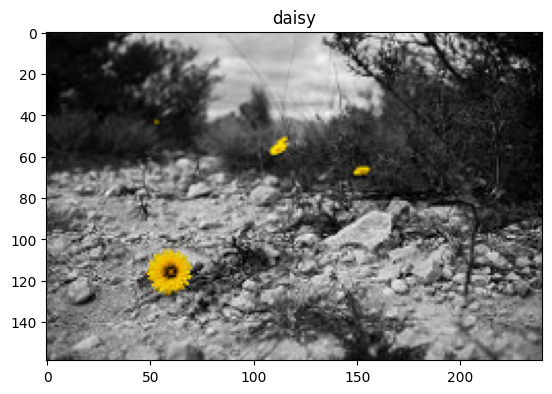

In [6]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

## Data Preparation

In [7]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [8]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [9]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 414 images belonging to 5 classes.
Found 101 images belonging to 5 classes.


In [10]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

## Modelling

**Membuat Arsitektur CNN**

Penyusunan Layer

In [11]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model CNN

In [12]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
13/13 [==============================] - 112s 8s/step - loss: 1.5602 - accuracy: 0.2343 - val_loss: 1.5248 - val_accuracy: 0.3663
Epoch 2/20
13/13 [==============================] - 44s 3s/step - loss: 1.3215 - accuracy: 0.4010 - val_loss: 1.4522 - val_accuracy: 0.3564
Epoch 3/20
13/13 [==============================] - 43s 3s/step - loss: 1.1690 - accuracy: 0.5266 - val_loss: 1.7314 - val_accuracy: 0.3366
Epoch 4/20
13/13 [==============================] - 43s 3s/step - loss: 1.1103 - accuracy: 0.5676 - val_loss: 1.8726 - val_accuracy: 0.3267
Epoch 5/20
13/13 [==============================] - 42s 3s/step - loss: 1.0578 - accuracy: 0.5531 - val_loss: 1.6770 - val_accuracy: 0.3069
Epoch 6/20
13/13 [==============================] - 42s 3s/step - loss: 0.9952 - accuracy: 0.5870 - val_loss: 1.5813 - val_accuracy: 0.3762
Epoch 7/20
13/13 [==============================] - 41s 3s/step - loss: 0.9730 - accuracy: 0.6087 - val_loss: 1.5820 - val_accuracy: 0.3366
Epoch 8/20
13/13 [=

Evaluasi Model CNN

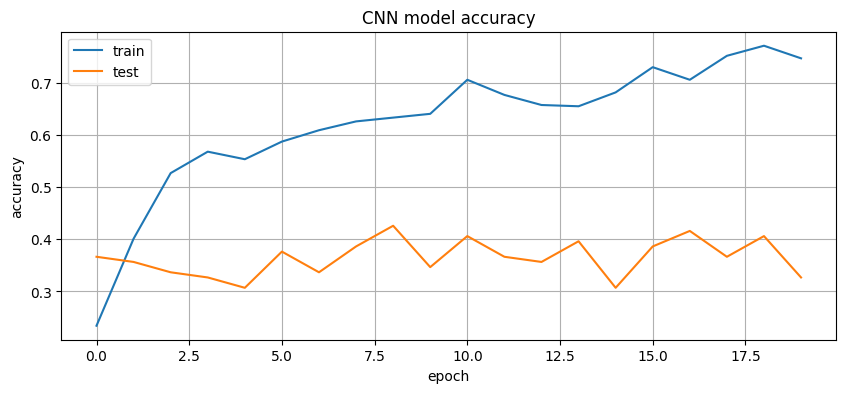

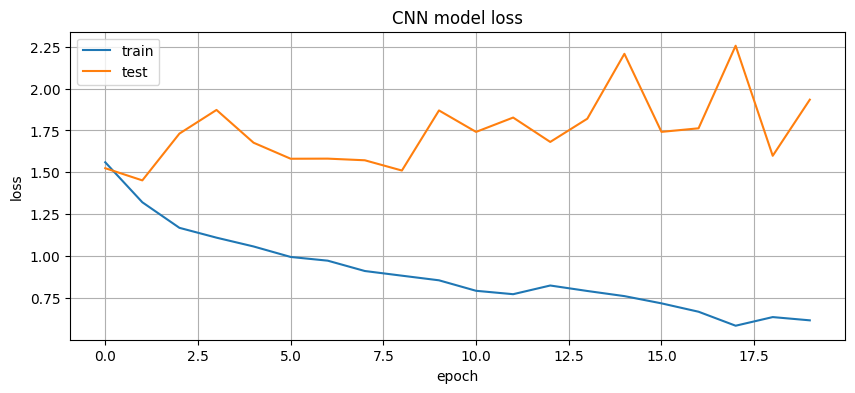

In [13]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Transfer Learning Menggunakan VGG16

Memuat Model VGG16

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [16]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
13/13 [==============================] - 237s 18s/step - loss: 1.7050 - accuracy: 0.2681 - val_loss: 1.4793 - val_accuracy: 0.3861
Epoch 2/20
13/13 [==============================] - 233s 18s/step - loss: 1.3999 - accuracy: 0.4034 - val_loss: 1.4125 - val_accuracy: 0.4356
Epoch 3/20
13/13 [==============================] - 270s 21s/step - loss: 1.2376 - accuracy: 0.4758 - val_loss: 1.3102 - val_accuracy: 0.4356
Epoch 4/20
13/13 [==============================] - 269s 21s/step - loss: 1.0824 - accuracy: 0.5845 - val_loss: 1.2135 - val_accuracy: 0.5248
Epoch 5/20
13/13 [==============================] - 270s 21s/step - loss: 0.8612 - accuracy: 0.6643 - val_loss: 1.2607 - val_accuracy: 0.5644
Epoch 6/20
13/13 [==============================] - 235s 18s/step - loss: 0.7521 - accuracy: 0.7560 - val_loss: 1.0984 - val_accuracy: 0.5644
Epoch 7/20
13/13 [==============================] - 269s 21s/step - loss: 0.6110 - accuracy: 0.7754 - val_loss: 1.1417 - val_accuracy: 0.5545
Epoch 

Evaluasi Model

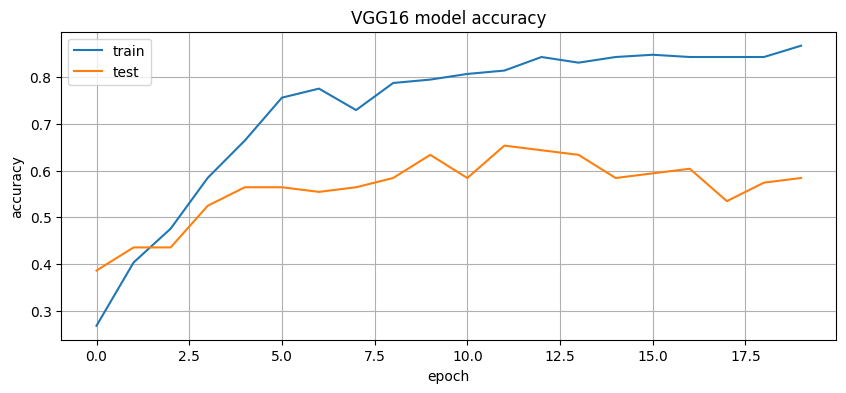

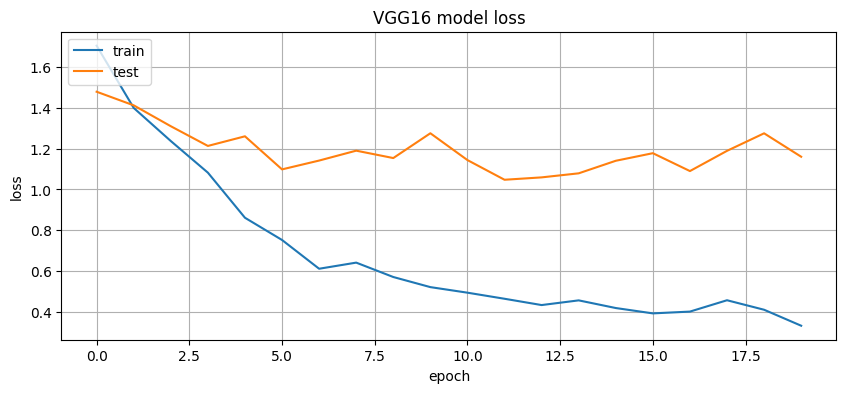

In [17]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Transfer Learning Menggunakan ResNet50

Memuat Model ResNet50

In [18]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])

94765736/94765736 [==============================] - 0s 0us/step


In [19]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [ ]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
13/13 [==============================] - 91s 7s/step - loss: 2.4693 - accuracy: 0.2053 - val_loss: 1.9646 - val_accuracy: 0.1980
Epoch 2/20
13/13 [==============================] - 91s 7s/step - loss: 1.7954 - accuracy: 0.2101 - val_loss: 1.9021 - val_accuracy: 0.1881
Epoch 3/20
13/13 [==============================] - 85s 7s/step - loss: 1.6808 - accuracy: 0.2488 - val_loss: 1.6494 - val_accuracy: 0.2673
Epoch 4/20
13/13 [==============================] - 90s 7s/step - loss: 1.6327 - accuracy: 0.2367 - val_loss: 1.6122 - val_accuracy: 0.1881
Epoch 5/20
13/13 [==============================] - 86s 7s/step - loss: 1.7115 - accuracy: 0.1908 - val_loss: 1.6322 - val_accuracy: 0.1881
Epoch 6/20
13/13 [==============================] - 90s 7s/step - loss: 1.7520 - accuracy: 0.2367 - val_loss: 1.6245 - val_accuracy: 0.2574
Epoch 7/20
13/13 [==============================] - 89s 7s/step - loss: 1.6745 - accuracy: 0.2343 - val_loss: 1.6904 - val_accuracy: 0.2277
Epoch 8/20
13/13 [==

Evaluasi Model

In [ ]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Transfer Learning Menggunakan DenseNet201

Memuat Model DenseNet201

In [ ]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

In [ ]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [ ]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Evaluasi Model

In [ ]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Evaluation
Setelah membuat beberapa model, maka dapat kita bandingkan akurasi dari model-model tersebut dengan visualisasi berikut ini.

In [ ]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

## Uji Coba Model

In [ ]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

In [ ]:
# Menguji coba model
import numpy as np
from keras.preprocessing import image
from google.colab import files
%matplotlib inline


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing
#atau kalian langsung import file gambarnya langsung
uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('daisy')
  elif classes==1:
    print('dandelion')
  elif classes==2:
    print('rose')
  elif classes==3:
    print('sunflower')
  else:
    print('tulip')

## Deployment
Agar nantinya dapat diimplementasikan atau dikembangkan lebih lanjut, model perlu dilakukan deploy terlebih dahulu dalam format HDF5, TFLite (Mobile) atau TensorflowJS (Web)

HDF5

In [ ]:
densenet_model.save('model-flowers-recognition.h5')

TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

TensorflowJS

tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers-recognition.h5 /content/modeltfjs